Nama  : Desi Nofitasari

NPM   : 24083010058

Kelas : Analisis Numerik A

**POIN 1 DAN 2 (TITIK MAKSIMUM,MINIMUM DAN ALIRAN SUNGAI)**

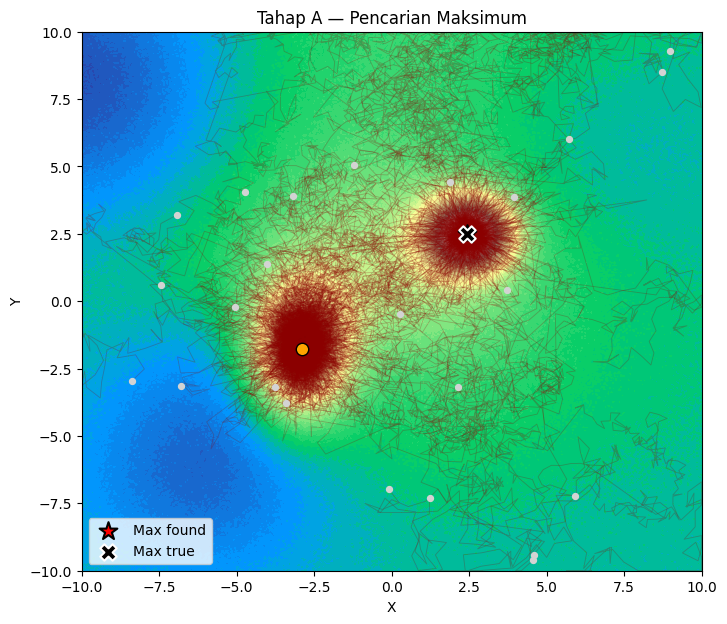

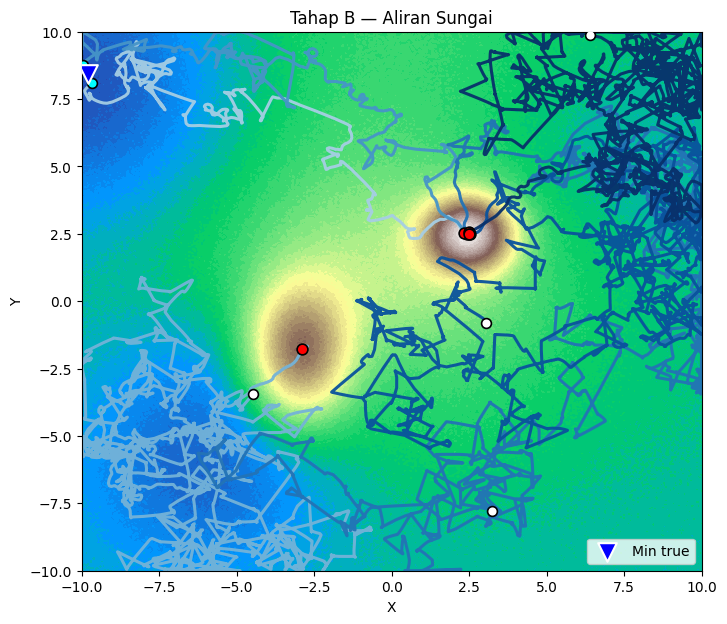


=== RINGKASAN AKHIR ===
Seed NPM = 58, Jumlah start maxima diuji : 6, mencapai lembah : 2/6
TRUE extrema:
  Max TRUE: pos=(2.4311,2.4812), val=5.299696
  Min TRUE: pos=(-9.7995,8.4461), val=-1.056149
FOUND extrema:
  Max FOUND: pos=(2.4299,2.4820), val=5.293730
    delta pos = 0.0015
    delta val = 0.005966
  Min target used (argmin) pos=(-9.7995,8.4461), val=-1.056149


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

NPM = 58
np.random.seed(NPM)
nx, ny = 400, 400
x = np.linspace(-10, 10, nx); y = np.linspace(-10, 10, ny)
X, Y = np.meshgrid(x, y)

def peak(x0, y0, sx, sy, amp):
    return amp * np.exp(-(((X-x0)**2)/(2*sx**2) + ((Y-y0)**2)/(2*sy**2)))

Z = (peak(-3,-2,1.2,1.8,3.2) + peak(2.5,2.5,1,1,4) + peak(0,0,3.5,3.5,1.2)
     + peak(6,6,4,4,-0.6) + peak(-10,8,3.5,3.5,-1.2) + peak(-6,-6,3,3,-1)
     + peak(-2,-2,4,2,-0.6) + peak(2.5,9.5,6,6,0.75))
Z += 0.5*np.exp(-np.sqrt((X/20)**2 + (Y/10)**2)) + 0.05*np.random.randn(*Z.shape)

# INTERPOLATION & GRADIENT
def f_at(xq,yq):
    i = np.clip(np.searchsorted(y, yq)-1,0,ny-2)
    j = np.clip(np.searchsorted(x, xq)-1,0,nx-2)
    tx, ty = (xq-x[j])/(x[j+1]-x[j]), (yq-y[i])/(y[i+1]-y[i])
    Q = Z[i:i+2,j:j+2]
    return ((1-tx)*(1-ty)*Q[0,0] + tx*(1-ty)*Q[0,1] + (1-tx)*ty*Q[1,0] + tx*ty*Q[1,1])

def numeric_grad(xq,yq,h=1e-3):
    return np.array([(f_at(xq+h,yq)-f_at(xq-h,yq))/(2*h),
                     (f_at(xq,yq+h)-f_at(xq,yq-h))/(2*h)])

# TRUE GLOBAL EXTREMA
min_idx, max_idx = np.unravel_index(np.argmin(Z),Z.shape), np.unravel_index(np.argmax(Z),Z.shape)
min_global_true = (X[min_idx], Y[min_idx], Z[min_idx])
max_global_true = (X[max_idx], Y[max_idx], Z[max_idx])

# BASIN-HOPPING MAXIMA
def climb_and_hop_max(start,n_steps=2000,step_grad=0.6,hop_prob=0.03,hop_scale=1.2,decay=0.0006):
    pos, best_pos, best_val, traj = np.array(start,dtype=float), np.array(start,dtype=float), f_at(*start), [start]
    for k in range(n_steps):
        g = numeric_grad(*pos)
        if np.linalg.norm(g) > 1e-12:
            pos += (g/np.linalg.norm(g))*step_grad/(1+decay*k)
        if np.random.rand() < hop_prob: pos += np.random.normal(scale=hop_scale, size=2)
        pos = np.clip(pos, [x[0],y[0]], [x[-1],y[-1]])
        val = f_at(*pos)
        if val > best_val: best_val, best_pos = val, pos.copy()
        traj.append(pos.copy())
    return np.array(traj), best_pos, best_val

# run multi-start
found_maxima, trajectories_max = [], []
for _ in range(24):
    start = np.random.uniform(x[0], x[-1], 2)
    traj, best_pos, best_val = climb_and_hop_max(start)
    for i,(p,v) in enumerate(found_maxima):
        if np.hypot(p[0]-best_pos[0],p[1]-best_pos[1])<0.5:
            if best_val>v: found_maxima[i]=(best_pos,best_val)
            break
    else: found_maxima.append((best_pos,best_val))
    trajectories_max.append((traj,start))

found_maxima.sort(key=lambda t:-t[1])
max_found_pos, max_found_val = (found_maxima[0] if found_maxima else (None,None))

# PLOT MAXIMAL
figA, axA = plt.subplots(figsize=(8,7))
axA.contourf(X,Y,Z,48,cmap='terrain')
# plot trajectories & start
for traj,start in trajectories_max:
    axA.plot(traj[:,0], traj[:,1], 'darkred', alpha=0.25, lw=0.6)
    axA.scatter(*start,c='lightgrey',s=18,zorder=3)
# plot found maxima
for p,v in found_maxima:
    axA.scatter(p[0],p[1],color='orange',edgecolors='k',s=80,zorder=5)
# highlight global found & true
if max_found_pos is not None:
    axA.scatter(max_found_pos[0], max_found_pos[1], color='red', marker='*', s=180,
               edgecolors='k', linewidths=1.5, zorder=10, label='Max found')
axA.scatter(max_global_true[0], max_global_true[1], color='black', marker='X', s=140,
           edgecolors='white', linewidths=1.5, zorder=11, label='Max true')
axA.set_title("Tahap A — Pencarian Maksimum")
axA.set_xlabel("X"); axA.set_ylabel("Y"); axA.legend(); plt.show()

# START POINTS FLOWS
start_points = [tuple(max_found_pos)] if max_found_pos is not None else []
start_points += [tuple(p) for p,v in found_maxima[1:6]]
if len(start_points)<6:
    for idx in np.argpartition(Z.flatten(),-8)[-8:]:
        j,i = np.unravel_index(idx,Z.shape); pt=(X[j,i],Y[j,i])
        if pt not in start_points: start_points.append(pt)
start_points = start_points[:6]

# FLOW TO MINIMUM
def flow_to_min(start,target,max_steps=8000,step_grad=0.12,hop_prob=0.03,hop_scale=0.5,tol_dist=0.35):
    pos, path = np.array(start,dtype=float), [start]
    for k in range(max_steps):
        g = numeric_grad(*pos)
        if np.linalg.norm(g)<1e-9: pos+=np.random.normal(scale=0.25, size=2)
        else: pos -= (g/np.linalg.norm(g))*step_grad/(1+0.0003*k)
        if np.random.rand()<hop_prob: pos+=np.random.normal(scale=hop_scale,size=2)
        pos = np.clip(pos,[x[0],y[0]],[x[-1],y[-1]])
        path.append(pos.copy())
        if np.hypot(*(pos-target))<tol_dist: return np.array(path), True
    return np.array(path), False

flows, success = [], 0
for sp in start_points:
    path, ok = flow_to_min(sp,(min_global_true[0],min_global_true[1]),max_steps=9000,step_grad=0.14,hop_prob=0.035,hop_scale=0.6,tol_dist=0.35)
    if path.shape[0]>4: path[:,0]=gaussian_filter1d(path[:,0],1); path[:,1]=gaussian_filter1d(path[:,1],1)
    flows.append((sp,path,ok)); success+=ok

# PLOT FLOWS
figB, axB = plt.subplots(figsize=(8,7))
axB.contourf(X,Y,Z,50,cmap='terrain')
colors = plt.cm.Blues(np.linspace(0.35,1,len(flows)))
for (sp,path,ok),c in zip(flows,colors):
    axB.plot(path[:,0],path[:,1],color=c,lw=2.2,alpha=0.95)
    axB.scatter(sp[0],sp[1],color='red',s=60,edgecolors='k',linewidths=1.2,zorder=5)
    axB.scatter(path[-1,0],path[-1,1],color='cyan' if ok else 'white',s=50,edgecolors='k',linewidths=1.2,zorder=5)
axB.scatter(min_global_true[0],min_global_true[1],color='blue',marker='v',s=180,edgecolors='white',linewidths=1.5,label='Min true',zorder=6)
axB.set_title("Tahap B — Aliran Sungai"); axB.set_xlabel("X"); axB.set_ylabel("Y"); axB.legend(); plt.show()

# SUMMARY
print("\n=== RINGKASAN AKHIR ===")
print(f"Seed NPM = {NPM}, Jumlah start maxima diuji : {len(start_points)}, mencapai lembah : {success}/{len(start_points)}")
print("TRUE extrema:"); print(f"  Max TRUE: pos=({max_global_true[0]:.4f},{max_global_true[1]:.4f}), val={max_global_true[2]:.6f}")
print(f"  Min TRUE: pos=({min_global_true[0]:.4f},{min_global_true[1]:.4f}), val={min_global_true[2]:.6f}")
print("FOUND extrema:")
if max_found_pos is not None:
    print(f"  Max FOUND: pos=({max_found_pos[0]:.4f},{max_found_pos[1]:.4f}), val={max_found_val:.6f}")
    print(f"    delta pos = {np.hypot(max_global_true[0]-max_found_pos[0], max_global_true[1]-max_found_pos[1]):.4f}")
    print(f"    delta val = {abs(max_global_true[2]-max_found_val):.6f}")
print(f"  Min target used (argmin) pos=({min_global_true[0]:.4f},{min_global_true[1]:.4f}), val={min_global_true[2]:.6f}")

Topografi diatas adalah topografi 2D yang menggabungkan beberapa puncak dan lembah Gaussian serta sedikit noise untuk variasi acak kemudian menyimpan ketinggian tiap titik di matriks Z berdasarkan grid X dan Y. Untuk memungkinkan perhitungan nilai ketinggian pada posisi non-grid saat optimasi atau aliran sungai digunakan interpolasi bilinear, yaitu menghitung nilai di titik acak sebagai kombinasi linear dari empat titik grid terdekat, sehingga trajektori bisa bergerak bebas. Gradien numerik dihitung dengan metode central difference untuk menentukan arah tercepat naik atau turun.


Karena fungsi yang diberikan terdapat banyak lembah dan bukit makan untuk menemukan maksimum lokal dan global, digunakan metode manual mirip algoritma basin-hopping, yaitu kombinasi gradient ascent dan random hop untuk menghindari terjebak di puncak lokal. Pada algoritma ini iterasi dimulai dari titik awal acak di mana setiap langkah bergerak naik gradien dengan skala step tertentu dan kadang juga melakukan hop acak untuk keluar dari puncak lokal sehingga bisa menemukan puncak yang lebih tinggi. Trajektori climb disimpan dan dibandingkan antar start point(titik mulai) untuk menyaring maksimum duplikat. Dari beberapa maksimum teratas, dipilih titik awal untuk mensimulasikan aliran sungai menuju minimum global menggunakan gradient descent dengan tambahan noise kecil. Kemudian path aliran dibuat lebih halus dengan Gaussian filter dan divisualisasikan sehingga terlihat jalur aliran dari puncak ke lembah dan perbandingan nilai extrema yang ditemukan dengan nilai global sebenarnya. Hasil akhirnya menampilkan perbandingan maksimum/minimum yang ditemukan dengan nilai true global, serta keberhasilan tiap jalur mencapai lembah.

Dari hasil percobaan beberapa kali didapatkan hasil final yang sesuai yaitu dari enam titik awal maksimum yang diuji ,dua di antaranya berhasil mencapai lembah global. Nilai maksimum dan minimum global sebenarnya masing-masing berada di posisi (2.4311, 2.4812) dengan nilai 5.2997, dan (-9.7995, 8.4461) dengan nilai -1.0561. Maksimum yang ditemukan melalui basin-hopping sangat dekat dengan nilai global, yaitu (2.4299, 2.4820) dengan nilai 5.2937, sehingga selisih posisi dan nilai hanya 0.0015 dan 0.006. Titik minimum yang digunakan sebagai target aliran sama persis dengan minimum global. Dari hasil ini beberapa percobaan penting terletak pada poin ((start,target,max_steps,step_grad,hop_prob,hop_scale, dan tol_dist)) ,yang sangat penting untuk diperhatikan karena akan memengaruhi hasil dari titik minimum dan aliran sungai.

**POIN 3 (KERAWANAN EROSI)**

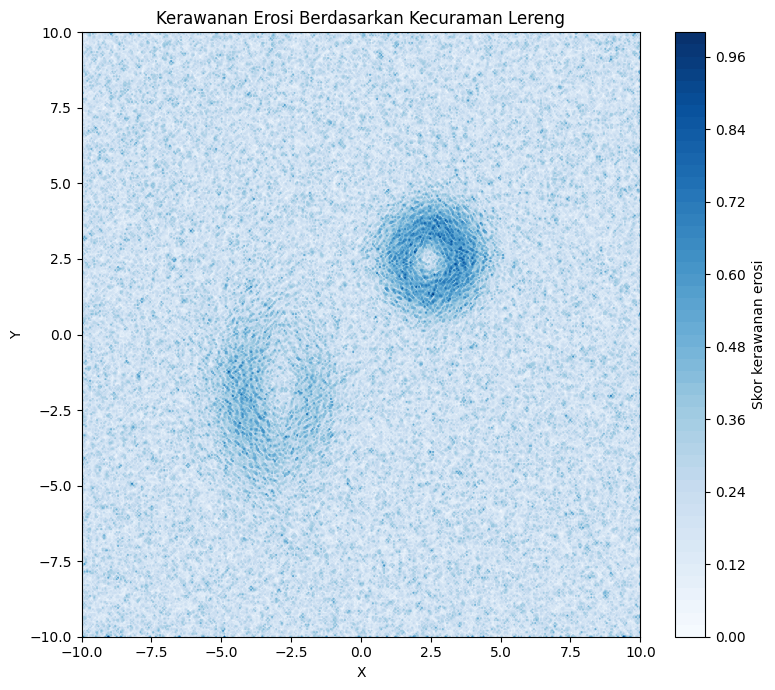

kerawanan erosi = [[0.36921598 0.66102487 0.36770733 ... 0.30823566 0.13246835 0.15426836]
 [0.14061172 0.11998224 0.31304822 ... 0.18872312 0.23801088 0.1170167 ]
 [0.02832567 0.15201166 0.35121742 ... 0.24431625 0.20562368 0.32936001]
 ...
 [0.21075632 0.11573237 0.05267302 ... 0.09369164 0.28521132 0.2058777 ]
 [0.08054463 0.06482482 0.22339196 ... 0.31371529 0.16531456 0.2807825 ]
 [0.16755668 0.22157501 0.27206846 ... 0.18794326 0.14175312 0.21712068]]


In [70]:
# TURUNAN PARSIAL
def manual_slope_score(Z_grid, x_grid, y_grid, normalize=True):
    """
    Hitung turunan parsial manual (central difference) dan magnitude gradien.
    Z_grid : elevasi 2D (ny, nx)
    x_grid, y_grid : koordinat 1D
    """
    ny, nx = Z_grid.shape
    dx = np.zeros_like(Z_grid)
    dy = np.zeros_like(Z_grid)

    hx = np.diff(x_grid)
    hy = np.diff(y_grid)

    for i in range(ny):
        for j in range(1, nx-1):
            dx[i,j] = (Z_grid[i,j+1] - Z_grid[i,j-1]) / (x_grid[j+1] - x_grid[j-1])
        # ujung kiri/kanan (forward/backward)
        dx[i,0] = (Z_grid[i,1] - Z_grid[i,0]) / (x_grid[1] - x_grid[0])
        dx[i,-1] = (Z_grid[i,-1] - Z_grid[i,-2]) / (x_grid[-1] - x_grid[-2])

    # turunan parsial dZ/dy (central difference)
    for j in range(nx):
        for i in range(1, ny-1):
            dy[i,j] = (Z_grid[i+1,j] - Z_grid[i-1,j]) / (y_grid[i+1] - y_grid[i-1])
        # ujung atas/bawah (forward/backward)
        dy[0,j] = (Z_grid[1,j] - Z_grid[0,j]) / (y_grid[1] - y_grid[0])
        dy[-1,j] = (Z_grid[-1,j] - Z_grid[-2,j]) / (y_grid[-1] - y_grid[-2])

    # resultan gradien
    slope_mag = np.hypot(dx, dy)

    # normalisasi ke 0..1
    if normalize:
        slope_mag = (slope_mag - slope_mag.min()) / (slope_mag.max() - slope_mag.min())

    return slope_mag

# hitung skor kerawanan erosi manual
erosion_score_manual = manual_slope_score(Z, x, y)

# PLOT kerawanan erosi manual
figE2, axE2 = plt.subplots(figsize=(8,7))
cf4 = axE2.contourf(X, Y, erosion_score_manual, levels=50, cmap='Blues')
plt.colorbar(cf4, ax=axE2, label='Skor kerawanan erosi')
axE2.set_title("Kerawanan Erosi Berdasarkan Kecuraman Lereng")
axE2.set_xlabel("X"); axE2.set_ylabel("Y")
plt.tight_layout()
plt.show()
print("kerawanan erosi =", erosion_score_manual)

Gambar tersebut menampilkan hasil visualisasi kerawanan erosi berdasarkan kecuraman lereng yang dihitung secara manual menggunakan metode turunan parsial yaitu central difference. Perhitungan dilakukan dengan menentukan perubahan nilai elevasi terhadap arah X dan Y pada setiap titik permukaan. Nilai perubahan tersebut menggambarkan turunan parsial yang menunjukkan tingkat kemiringan lereng atau slope. Semakin besar perubahan elevasi antar titik, semakin curam lerengnya sehingga potensi erosi juga semakin tinggi. Fungsi manual_slope_score() digunakan untuk menghitung gradien elevasi secara numerik dengan pendekatan central difference untuk titik tengah serta forward dan backward difference untuk titik tepi.

Hasil perhitungan menghasilkan nilai magnitudo gradien yang kemudian dinormalisasi ke dalam skala 0-1 agar mudah divisualisasikan. Pada peta kontur, warna biru muda menggambarkan daerah dengan kemiringan landai atau tingkat kerawanan erosi yang rendah sedangkan warna biru tua menunjukkan daerah dengan lereng yang curam dan tingkat kerawanan erosi yang tinggi. Visualisasi ini memberikan gambaran spasial mengenai distribusi potensi erosi di permukaan, sehingga dapat digunakan untuk mengidentifikasi area yang perlu mendapatkan perhatian lebih dalam pengelolaan lahan dan konservasi tanah.

Dalam dunia nyata, lereng yang lebih curam cenderung mengalami aliran air yang lebih cepat saat hujan sehingga tanah mudah tergerus. Contohnya pada daerah perbukitan atau pegunungan, area dengan gradien tinggi akan lebih rawan longsor atau kehilangan lapisan tanah subur sedangkan area datar cenderung lebih stabil. Informasi ini penting untuk perencanaan tata ruang, konservasi tanah, dan pertanian berkelanjutan, karena membantu menentukan lokasi yang aman untuk pembangunan, area yang perlu revegetasi atau penahan air agar meminimalkan erosi.

**POIN 4A DAN 4B (CUT & FILL PERMUKAAN )**

Volume tanah dipotong (cut): 109.965
Volume tanah diurug (fill): 109.965
Ketinggian tanah awal: min=-1.056, max=5.300, rata-rata=0.501
Ketinggian tanah akhir: min=0.501, max=0.501, rata-rata=0.501


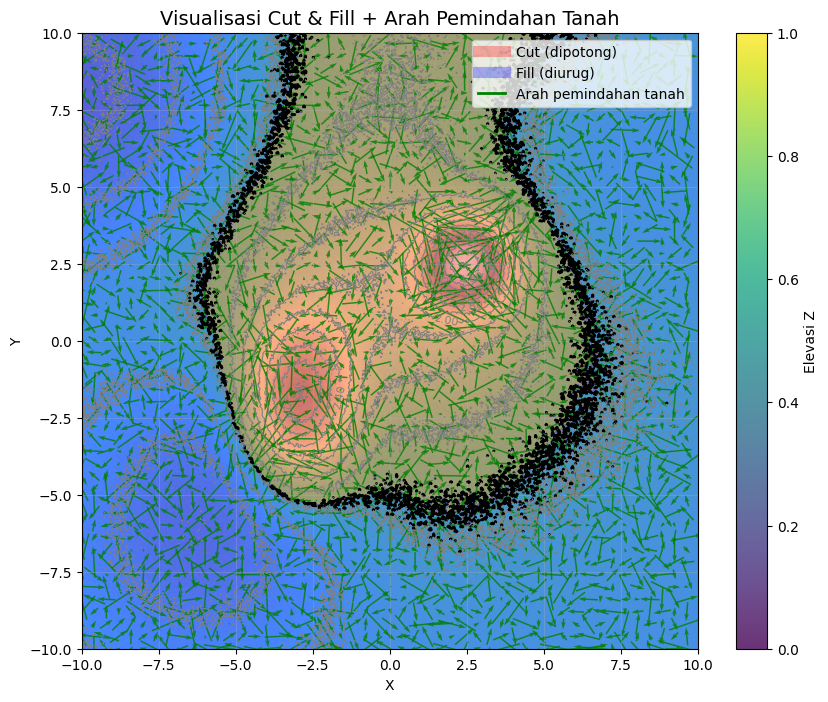

In [69]:
# rata-rata ketinggian untuk perataan
Z_mean = np.mean(Z)

# ===== 2. Hitung mask cut & fill =====
cut_mask  = Z > Z_mean
fill_mask = Z < Z_mean

# ===== 3. Hitung volume tanah =====
dx = x[1] - x[0]  # ukuran grid di x
dy = y[1] - y[0]  # ukuran grid di y
area_per_cell = dx * dy

volume_cut  = np.sum((Z[cut_mask] - Z_mean) * area_per_cell)
volume_fill = np.sum((Z_mean - Z[fill_mask]) * area_per_cell)

print(f"Volume tanah dipotong (cut): {volume_cut:.3f}")
print(f"Volume tanah diurug (fill): {volume_fill:.3f}")

# ===== 4. Gradien arah pemindahan tanah =====
dZdx, dZdy = np.gradient(Z, x, y)
u = -dZdx
v = -dZdy

# ===== 5. Ketinggian tanah akhir =====
Z_final = np.copy(Z)
Z_final[cut_mask]  = Z_mean
Z_final[fill_mask] = Z_mean

print(f"Ketinggian tanah awal: min={Z.min():.3f}, max={Z.max():.3f}, rata-rata={Z.mean():.3f}")
print(f"Ketinggian tanah akhir: min={Z_final.min():.3f}, max={Z_final.max():.3f}, rata-rata={Z_final.mean():.3f}")

# ===== 6. Visualisasi =====
plt.figure(figsize=(10,8))
plt.imshow(Z, extent=[x.min(), x.max(), y.min(), y.max()],
           origin='lower', cmap='terrain', alpha=0.6)
cs = plt.contour(X, Y, Z, levels=15, colors='gray', linewidths=0.8)
plt.clabel(cs, inline=True, fontsize=8, fmt="%.2f")
plt.contourf(X, Y, cut_mask, levels=[0.5,1], colors=['red'], alpha=0.3)
plt.contourf(X, Y, fill_mask, levels=[0.5,1], colors=['blue'], alpha=0.3)
plt.contour(X, Y, Z, levels=[Z_mean], colors='black', linewidths=2, linestyles='--')

skip = (slice(None,None,8), slice(None,None,8))
plt.quiver(X[skip], Y[skip], u[skip], v[skip],
           color='green', scale=30, alpha=0.8, pivot='middle')

plt.plot([], [], color='red', lw=8, alpha=0.3, label='Cut (dipotong)')
plt.plot([], [], color='blue', lw=8, alpha=0.3, label='Fill (diurug)')
plt.plot([], [], color='green', lw=2, label='Arah pemindahan tanah')

plt.title("Visualisasi Cut & Fill + Arah Pemindahan Tanah", fontsize=14)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.colorbar(label='Elevasi Z')
plt.show()

Gambar ini menampilkan hasil simulasi cut and fill atau proses pemotongan dan penimbunan tanah yang dilakukan untuk meratakan permukaan lahan. Berdasarkan hasil perhitungan, volume tanah yang dipotong (cut) dan volume tanah yang diurug (fill) memiliki nilai yang sama besar yaitu sekitar 109.965 m^2. Nilai ini menunjukkan bahwa tanah hasil galian sudah cukup untuk menimbun area yang lebih rendah sehingga tidak ada tanah yang perlu dibuang atau ditambahkan dari luar lokasi. Dari data elevasi, ketinggian tanah awal memiliki nilai minimum sekitar -1.056, maksimum 5.300, dan rata-rata 0.501. Setelah proses cut and fill dilakukan, ketinggian tanah akhir menjadi seragam dengan nilai minimum, maksimum, dan rata-rata yang sama yaitu 0.501. Kondisi ini menunjukkan bahwa permukaan tanah sudah benar-benar rata dan mencapai keseimbangan tanah (earthwork balance) secara sempurna.

Dalam kehidupan nyata, analisis seperti ini sangat penting di bidang teknik sipil dan perencanaan lahan. Contohnya ketika merancang jalan, lapangan, atau area perumahan, insinyur perlu memastikan berapa volume tanah yang harus dipotong dari area tinggi dan diurug ke area rendah agar permukaannya rata. Pada visualisasi, warna merah menunjukkan bagian yang perlu dipotong, warna biru menunjukkan area yang diurug, sedangkan panah hijau menggambarkan arah perpindahan tanah dari daerah tinggi menuju rendah. Dari hasil ini dapat disimpulkan bahwa desain perataan lahan sudah optimal karena menghasilkan permukaan datar dengan keseimbangan volume dan ketinggian yang ideal, sehingga efisien dari segi biaya, waktu, dan tenaga kerja. Dengan memahami hasil ini maka dapat melihat bagaimana prinsip efisiensi pemindahan tanah (earthwork efficiency) diterapkan secara praktis dalam proyek nyata untuk mencapai keseimbangan volume tanah yang ideal.